In [1]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
import datetime as dt
import time
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('expand_frame_repr', False)  # show all column in a raw
pd.set_option('display.max_rows', None) # show all rows


In [2]:
def strategy(df, initial, call_pos, put_pos, L, S, X, Y, C):
    df['cash'].iloc[0] = initial
    df['futures'].iloc[0] = 0
    df['account'].iloc[0] = df['cash'].iloc[0] + df['futures'].iloc[0]
    for i in range(1, len(df)):
        #price of B over its MA X std
        if df['Close_B'].iloc[i] > df['MA_B'].iloc[i] + X * df['Std_B'].iloc[i]:
            if call_pos < L:
                call_pos += 1
                df['callsignal'].iloc[i] = 1
                df['call_pos'].iloc[i] = call_pos
                df['cash'].iloc[i] = df['cash'].iloc[i-1] - (df['Last_A'].iloc[i]+C)
                df['futures'].iloc[i] = df['Last_A'].iloc[i] * (call_pos - put_pos)
                df['account'].iloc[i] = df['cash'].iloc[i] + df['futures'].iloc[i]
            elif call_pos == L:
                df['callsignal'].iloc[i] = 0
                df['call_pos'].iloc[i] = call_pos
                df['cash'].iloc[i] = df['cash'].iloc[i-1]
                df['futures'].iloc[i] = df['Last_A'].iloc[i] * (call_pos - put_pos)
                df['account'].iloc[i] = df['cash'].iloc[i] + df['futures'].iloc[i]
            else:
                return 'call_pos > L'
                
        #price of B beneath its MA Y std        
        elif df['Close_B'].iloc[i] < df['MA_B'].iloc[i] - Y * df['Std_B'].iloc[i]:
            if put_pos < S:
                put_pos += 1
                df['putsignal'].iloc[i] = 1
                df['put_pos'].iloc[i] = put_pos
                df['cash'].iloc[i] = df['cash'].iloc[i-1] + (df['Last_A'].iloc[i]-C)
                df['futures'].iloc[i] = df['Last_A'].iloc[i] * (call_pos - put_pos)
                df['account'].iloc[i] = df['cash'].iloc[i] + df['futures'].iloc[i]

            elif put_pos == S:
                df['putsignal'].iloc[i] = 0
                df['put_pos'].iloc[i] = put_pos
                df['cash'].iloc[i] = df['cash'].iloc[i-1]
                df['futures'].iloc[i] = df['Last_A'].iloc[i] * (call_pos - put_pos)
                df['account'].iloc[i] = df['cash'].iloc[i] + df['futures'].iloc[i]
            else:
                return 'put_pos > S'

        #other cases
        else:
            df['cash'].iloc[i] = df['cash'].iloc[i-1] + (df['Last_A'].iloc[i]-C) * call_pos - (df['Last_A'].iloc[i]+C) * put_pos
            df['callsignal'].iloc[i] = -call_pos
            call_pos = 0
            df['putsignal'].iloc[i] = -put_pos
            put_pos = 0
            df['futures'].iloc[i] = 0
            df['account'].iloc[i] = df['cash'].iloc[i] + df['futures'].iloc[i]
    return df

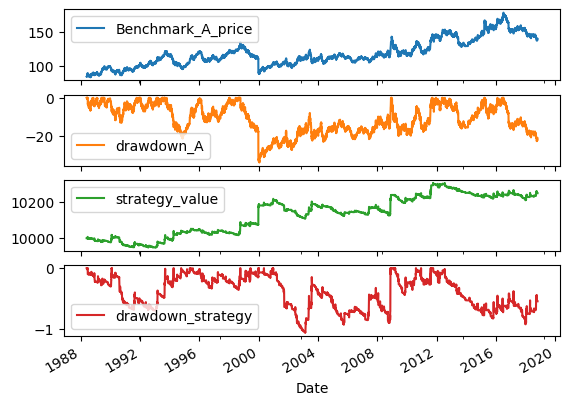

         Date  Last_A_yesterday   Last_A  callsignal  putsignal  call_pos  put_pos        cash   futures     account  drawdown  return  cumreturn
0  1988-05-20           85.7812  85.4375           0          0         0        0  10000.0000    0.0000  10000.0000  0.000000  0.0000     0.0000
1  1988-05-23           85.4375  85.3125           0          0         0        0  10000.0000    0.0000  10000.0000  0.000000  0.0000     0.0000
2  1988-05-24           85.3125  85.4688           0          0         0        0  10000.0000    0.0000  10000.0000  0.000000  0.0000     0.0000
3  1988-05-25           85.4688  85.7500           0          0         0        0  10000.0000    0.0000  10000.0000  0.000000  0.0000     0.0000
4  1988-05-26           85.7500  85.6562           0          0         0        0  10000.0000    0.0000  10000.0000  0.000000  0.0000     0.0000
5  1988-05-27           85.6562  85.5000           0          1         0        1  10085.4900  -85.5000   9999.9900 -0.0001

In [3]:
if __name__ == '__main__':
    # import data and data cleaning
    data_a = pd.read_csv(r'futuresA.csv')
    data_b = pd.read_csv(r'futuresB.csv')
    # print(data_a)
    # print(data_b)
    data = pd.merge(data_a, data_b, on='Date', how='left')
    data = data.rename(columns={"Last": "Last_A", "Close": "Close_B"})
    # data = pd.merge_asof(left=data_a, right=data_b, left_on='Date', right_on='Date', direction='backward')
    data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
    data = data.sort_values(by='Date', ascending=True, ignore_index=True)
    #print(data)
    df = data.copy()
    df['Last_A_yesterday'] = df['Last_A'].shift(1)
    df = df.dropna(axis=0, subset=['Close_B'])
    df = df.reset_index(drop=True)
    df['Last_A'] = df['Last_A'].fillna(method='ffill')
    df['cash'] = 0
    df['futures'] = 0
    df['account'] = 0
    #print(df)

    
    # initialization
    initial = 10000
    N = 26 # span of ewm
    L = 10 # largest num of Long positon
    S = 10 # largest num of Short positon
    X = 1 # above X std
    Y = 1 # below Y std
    C = 0.01 # fee
    call_pos = 0 # call position
    put_pos = 0 # put position
    # df['L'] = L * df['account']/df['Last_A']
    # df['S'] = S * df['account']/df['Last_A']
    df['fee'] = 0
    df['MA_B'] = df['Close_B'].ewm(span=N).mean()
    df['Std_B'] = df['Close_B'].ewm(span=N).std()
    df['callsignal'] = 0
    df['putsignal'] = 0
    df['call_pos'] = 0
    df['put_pos'] = 0

    
    #exacute strategy
    strategy(df, initial, call_pos, put_pos, L, S, X, Y, C)

    
    #culculate the result
    df['call_pos_yesterday'] = df['call_pos'].shift(1)
    df['call_pos_yesterday'] = df['call_pos_yesterday'].fillna(0)
    df['put_pos_yesterday'] = df['put_pos'].shift(1)
    df['put_pos_yesterday'] = df['put_pos_yesterday'].fillna(0)
    df['fee'] = (abs(df['callsignal'])+abs(df['putsignal']))*C
    df['return'] = (df['Last_A']-df['Last_A_yesterday']) * (df['call_pos_yesterday']) - (df['Last_A']-df['Last_A_yesterday']) * (df['put_pos_yesterday']) - df['fee']
    df['return'] = df['return'].fillna(0)
    df['cumreturn'] = df['return'].cumsum()
    #highest account in the history
    df['account_max'] = df['account'].expanding().max()
    df['A_max'] = df['Last_A'].expanding().max()
    #df['cumreturn_max'] = df['cumreturn'].rolling(window=1000,min_periods=1).max()
    #df['withdraw'] = (df['cumreturn'] - df['cumreturn_max'])/ df['cumreturn_max']
    df['drawdown'] = np.divide(100*(df['account']-df['account_max']), df['account_max'], out = np.zeros_like(100*(df['account']-df['account_max'])), where=df['account_max']!=0)
    df['drawdown_A'] = np.divide(100*(df['Last_A']-df['A_max']), df['A_max'], out = np.zeros_like(100*(df['Last_A']-df['A_max'])), where=df['Last_A']!=0)

    
    #display the result
    draw = df[['Date', 'Last_A', 'drawdown_A', 'account', 'drawdown']].copy()
    draw = draw.rename(columns={"Last_A": "Benchmark_A_price", "account": "strategy_value", "drawdown": "drawdown_strategy"})
    draw.set_index(['Date'], inplace=True)
    draw.plot(kind='line', subplots=True) 
    plt.show()

    df = df[['Date', 'Last_A_yesterday', 'Last_A', 'callsignal', 'putsignal', 'call_pos', 'put_pos', 'cash', 'futures', 'account', 'drawdown', 'return', 'cumreturn']]
    print(df.head(100))
    print(df.tail(100))

    annual_return = (df['account'].iloc[-1] / df['account'].iloc[0]) ** ('1 days 00:00:00' / (df['Date'].iloc[-1] - df['Date'].iloc[0])* 365 ) -1
    print('annual_return=%s%%' % annual_return)
    sharpe_ratio = df['cumreturn'].iloc[-1] / df['cumreturn'].std(ddof=1)
    print('sharpe_ratio=%s' % sharpe_ratio)
    max_drawdown = df['drawdown'].min()
    print('max_drawdown=%s%%' % max_drawdown)